In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   #Data visualisation libraries 
import seaborn as sns

In [94]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_subf = pd.read_csv('sample_submission.csv')

In [95]:
def normalizePrice (label):
    if label['currency'] == 'USD':
        return label['price']
    elif label['currency'] == 'EUR':
        return (label['price']*1.12)
    elif label['currency'] == 'AUD':
        return (label['price'] *0.7)
    elif label['currency'] == 'HKD':
        return (label['price']*0.13)
    elif label['currency'] == 'INR':
        return (label['price']*0.014)
    elif label['currency'] == 'KRW':
        return (label['price']*0.00085)
    else :
        return -1
df_train['price'] = df_train.apply (lambda row: normalizePrice(row), axis=1)
#1 USD (approx.) = 0.7 AUD or 1.12 EUR or 0.13 HKD or 0.014 INR or 0.00085 KRW

df_train['price']=df_train['price']/df_train['number_of_passengers']

In [96]:
# Outliers
df_train = df_train.drop(df_train[df_train['id'] == 51950].index)
df_train = df_train.drop(df_train[df_train['id'] == 85045].index)
df_train = df_train.drop(df_train[df_train['id'] == 89623].index)
df_train = df_train.drop(df_train[df_train['id'] == 57157].index)
df_train = df_train.drop(df_train[df_train['id'] == 56666].index)
df_train = df_train.drop(df_train[df_train['id'] == 77202].index)
df_train = df_train.drop(df_train[df_train['id'] == 19741].index)

In [97]:
y=df_train['price']

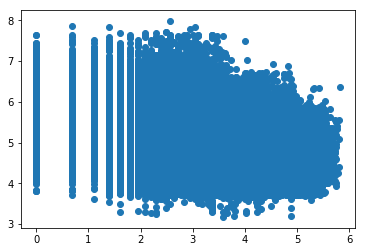

In [98]:
plt.scatter(np.log1p(df_train['advance_purchase']),np.log1p(df_train['price']));

In [99]:
df_train = df_train.drop(['price'],axis=1)
df = pd.concat([df_train, df_test],sort=False).reset_index(drop=True)
df.head(10)

,id,search_date,origin,destination,distance,departure_date,departure_time,departure_day_of_week,advance_purchase,eft,carrier,cabin,rbd,aircraft,number_of_passengers,country,currency
0,1,20181212,BOS,ORD,1390,20181230,705,Sun,18,2.850,UA,M,N,738,2,US,USD
1,2,20181225,LAX,LAS,380,20181226,1455,Wed,1,1.250,AS,M,H,32S,2,GR,EUR
2,3,20181220,JFK,FLL,1723,20190112,2132,Sat,23,3.117,B6,M,P,321,3,US,USD
3,4,20181209,SEA,SFO,1093,20181213,950,Thu,4,2.267,AS,M,B,32S,1,AU,AUD
4,5,20181231,SFO,LAX,543,20190108,835,Tue,8,1.717,AA,M,L,E75,2,AU,AUD
5,6,20181214,SFO,FLL,4151,20190105,2359,Sat,22,5.283,B6,M,O,32S,2,US,USD
6,7,20181229,SFO,SEA,1093,20190104,920,Fri,6,2.217,UA,M,W,739,1,NL,EUR
7,8,20181221,ORD,MIA,1930,20190110,1905,Thu,20,3.117,UA,M,N,739,2,US,USD
8,9,20181205,ORD,SFO,2964,20190101,1650,Tue,27,5.133,AS,M,B,32S,4,GR,EUR
9,10,20181230,SFO,LAX,543,20190520,1420,Mon,141,1.583,AS,M,R,73J,1,HK,HKD


In [100]:
df_subf['number_of_passengers'] = df_test['number_of_passengers']
df_subf['currency'] = df_test['currency']


In [101]:
df['departure_date'] = pd.to_datetime(df['departure_date'], format='%Y%m%d',exact=True).dt.normalize()
df['year'] = df.departure_date.dt.year.astype(str)
# df['week'] = df.departure_date.dt.week.astype(str)
df['month'] = df.departure_date.dt.month.astype(str)
df['day'] = df.departure_date.dt.day.astype(str)

# Encode depature time
df['departure_time'] = df['departure_time'].apply(lambda x: int(x / 600)).astype(str)

df['origin_destination'] = df_train['origin'] + '-' + df_train['destination']
df['is_weekend'] = df['departure_day_of_week'].apply(lambda x: x in ['Fri', 'Sat', 'Sun']).astype(str)
df['advance_purchase'] =  df['advance_purchase'].apply(lambda x: x if x < 90 else 90)
df['advance_purchase']= np.log1p(df['advance_purchase'])


# df['distance']= np.log1p(df['distance'])
y= np.log1p(y)


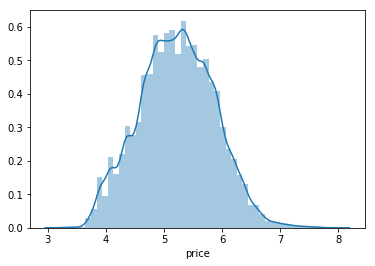

In [102]:
sns.distplot(y)


In [103]:
# df = df.sort_values(['origin_destination'], ascending=True)

In [104]:
df = df.drop([ 'search_date','departure_date', 'origin', 'destination', 'departure_day_of_week',
'number_of_passengers'], axis = 1)
df.head()


,id,distance,departure_time,advance_purchase,eft,carrier,cabin,rbd,aircraft,country,currency,year,month,day,origin_destination,is_weekend
0,1,1390,1,2.944439,2.850,UA,M,N,738,US,USD,2018,12,30,BOS-ORD,True
1,2,380,2,0.693147,1.250,AS,M,H,32S,GR,EUR,2018,12,26,LAX-LAS,False
2,3,1723,3,3.178054,3.117,B6,M,P,321,US,USD,2019,1,12,JFK-FLL,True
3,4,1093,1,1.609438,2.267,AS,M,B,32S,AU,AUD,2018,12,13,SEA-SFO,False
4,5,543,1,2.197225,1.717,AA,M,L,E75,AU,AUD,2019,1,8,SFO-LAX,False


In [105]:
df = pd.get_dummies(df)
df.head()

,id,distance,advance_purchase,eft,departure_time_0,departure_time_1,departure_time_2,departure_time_3,carrier_AA,carrier_AS,...,origin_destination_SFO-FLL,origin_destination_SFO-JFK,origin_destination_SFO-LAS,origin_destination_SFO-LAX,origin_destination_SFO-MCO,origin_destination_SFO-MIA,origin_destination_SFO-ORD,origin_destination_SFO-SEA,is_weekend_False,is_weekend_True
0,1,1390,2.944439,2.850,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,380,0.693147,1.250,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,3,1723,3.178054,3.117,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1093,1.609438,2.267,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,5,543,2.197225,1.717,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [106]:
df = df.drop(['id'], axis = 1)
X = df.iloc[:len(y),:]
X_sub = df.iloc[len(y):,:]


In [107]:
from sklearn.model_selection import train_test_split

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
X_train.shape

(79994, 301)

In [109]:
from sklearn.linear_model import LinearRegression


In [110]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)
rf_model.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 18.4min finished


In [111]:
# lr_model = LinearRegression()
# lr_model.fit(X_train,y_train)
# lr_model.score(X_test, y_test)

In [112]:
# features = X_train.columns.values
# importances = rf_model.feature_importances_
# indices = np.argsort(importances)

# plt.title('Feature Importances')
# plt.xlabel('Relative Importance')
# f, ax = plt.subplots(figsize=(100, 6))
# plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.show()

In [113]:
predictions = rf_model.predict(np.array(X_test))
predictions

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    2.7s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    5.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    5.9s finished


array([5.0761822 , 4.74447348, 4.93260441, ..., 4.25988905, 4.92538879,
       4.71697341])

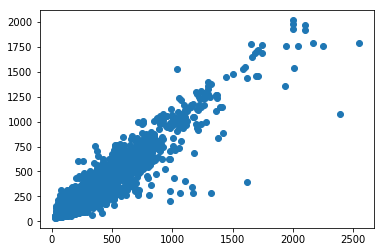

In [114]:
plt.scatter(np.expm1(y_test),np.expm1(predictions))

In [115]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(np.expm1(y_true)), np.array(np.expm1(y_pred))
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(y_test, predictions)

11.369881953654733

In [116]:
X_sub.head()

,distance,advance_purchase,eft,departure_time_0,departure_time_1,departure_time_2,departure_time_3,carrier_AA,carrier_AS,carrier_B6,...,origin_destination_SFO-FLL,origin_destination_SFO-JFK,origin_destination_SFO-LAS,origin_destination_SFO-LAX,origin_destination_SFO-MCO,origin_destination_SFO-MIA,origin_destination_SFO-ORD,origin_destination_SFO-SEA,is_weekend_False,is_weekend_True
99993,1537,4.127134,3.183,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
99994,1510,3.295837,2.900,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
99995,1510,3.465736,2.967,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
99996,1723,1.386294,2.817,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
99997,3494,2.772589,5.800,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [117]:
y_sub = rf_model.predict(X_sub)
# y_sub = rf_model.predict(np.array(X_sub))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.6s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    6.6s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   12.1s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:   15.4s finished


In [118]:
y_sub = np.expm1(y_sub)

In [119]:
def deNormailzeCurrency (label):
    if label['currency'] == 'USD':
        return label['price']
    elif label['currency'] == 'EUR':
        return np.float32(label['price']/1.12)
    elif label['currency'] == 'AUD':
        return (label['price'] /0.7)
    elif label['currency'] == 'HKD':
        return (label['price']/0.13)
    elif label['currency'] == 'INR':
        return (label['price']/0.014)
    elif label['currency'] == 'KRW':
        return (label['price']/0.00085)
    else :
        return -1

In [120]:
df_subf.iloc[:,1] = y_sub
df_subf.head()

,id,price,number_of_passengers,currency
0,100001,91.368859,2,INR
1,100002,119.661451,4,USD
2,100003,73.293255,4,USD
3,100004,450.774155,4,USD
4,100005,354.466789,1,USD


In [121]:
df_subf['price'] = (df_subf['price'] * np.float32(df_subf['number_of_passengers']))
df_subf['price'] = df_subf.apply (lambda row: deNormailzeCurrency(row), axis=1)
df_subf.head()

,id,price,number_of_passengers,currency
0,100001,13052.694183,2,INR
1,100002,478.645804,4,USD
2,100003,293.173020,4,USD
3,100004,1803.096621,4,USD
4,100005,354.466789,1,USD


In [122]:
df_subf.to_csv("sample_submission_result.csv", columns = ['id','price'], index = False)